In [1]:
#  ! pip install mysql-connector-python

from sqlalchemy import create_engine

# SQL flavor, user, password
engineStr = 'mysql+mysqlconnector://student:cbasummer2020' 
engineStr += '@35.202.92.40:3306' # Server Address
engineStr += '/nfl' # Database Name

engine = create_engine(engineStr) # Start the Engine

In [8]:
import pandas as pd

select = """
SELECT
  pbp.DWN as down,
  pbp.TYPE as type,
  pbp.YTG as toGo,
  pbp.YDS AS success
FROM pbp
JOIN game
  ON pbp.GID = game.GID
WHERE game.SEAS=2019 AND pbp.TYPE IN ("PASS", "RUSH") AND pbp.OFF='SEA';
"""

data = pd.read_sql(select, engine)

In [9]:
data['pass'] = (data['type']=="PASS")
data['pass'] = data['pass'].astype(int)
# data['success'] = (data['success']=="Y")
# data['success'] = data['success'].astype(int)

In [10]:
data = data[['success', 'pass', 'down', 'toGo']]

In [ ]:
data.to_csv("nfl_pass_rush_success.csv", index=False)

In [ ]:
! pip install pymc3 arviz

In [7]:
data = pd.read_csv("nfl_pass_rush_success.csv")

In [11]:
import pymc3 as pm
import numpy as np

coords = {"observation": data.index.values}

with pm.Model(coords=coords) as binomial_regression_model:
    n = data.shape[0]
    passes = pm.Data("passes", data['pass'], dims="observation")
    down = pm.Data("down", data['down'], dims="observation")
    distance = pm.Data("distance", data['toGo'], dims="observation")
    # priors
    β0 = pm.Normal("β0", mu=0, sigma=1)
    β_pass = pm.Normal("β_pass", mu=0, sigma=1)
    β_down = pm.Normal("β_down", mu=0, sigma=1)
    β_distance = pm.Normal("β_distance", mu=0, sigma=1)
    # linear model
    μ = β0 + β_pass * passes + β_down * down + β_distance * distance
    sigma = pm.HalfNormal("sigma", sigma=5, testval=1.0)
    
    likelihood = pm.Normal("y", mu=μ, sigma=sigma, observed=data['success'])

    
#     LOGIT CODE
# #     μ = β0 + β_pass * passes 
#     p = pm.Deterministic("p", pm.math.invlogit(μ), dims="observation")
#     # likelihood
#     pm.Binomial("y", n=n, p=p, observed=data["success"], dims="observation")

In [12]:
with binomial_regression_model:
    #fit the data 
    start=pm.find_MAP()
    step=pm.Metropolis()
    
    #samples from posterior distribution 
    trace=pm.sample(10000, step=step, start=start)
    burned_trace=trace[4000:]

<ipython-input-12-0677c34069bc>:7: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace=pm.sample(10000, step=step, start=start)
/home/dusty/anaconda3/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [β_distance]
>Metropolis: [β_down]
>Metropolis: [β_pass]
>Metropolis: [β0]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 32 seconds.
The number of effective samples is smaller than 10% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
/home/dusty/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


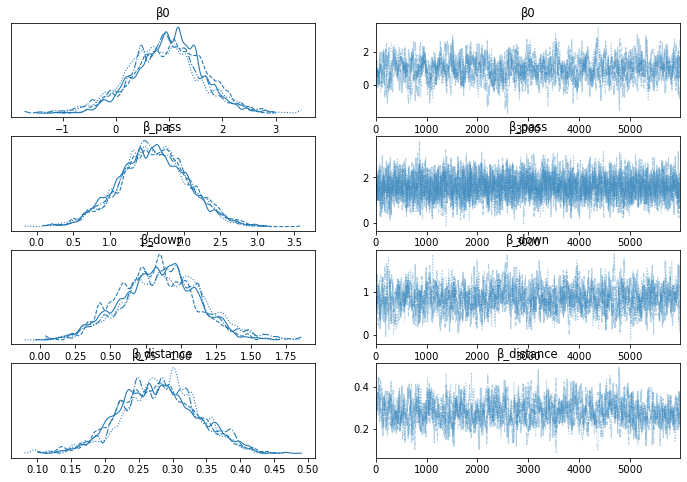

In [14]:
import arviz as az

az.plot_trace(burned_trace, var_names=["β0","β_pass", "β_down", "β_distance"]);

In [ ]:
! pip install graphviz cachetools

In [ ]:
fig = pm.model_to_graphviz(binomial_regression_model)

print(fig.source)

In [30]:
def linear(x_pass, x_down, x_distance, b_pass, b_down, b_distance, b0):
    x = np.array([[1, x_pass, x_down, x_distance]])
    betas = np.array([b0, b_pass, b_down, b_distance]).squeeze()
    return np.dot(x, betas)

b0 = burned_trace["β0"][:, None]  # best to make them 1d
b_pass = burned_trace["β_pass"][:, None]
b_down = burned_trace["β_down"][:, None]
b_distance = burned_trace["β_distance"][:, None]

In [31]:
import seaborn as sns

distance = 10

(3.0, 8.0)

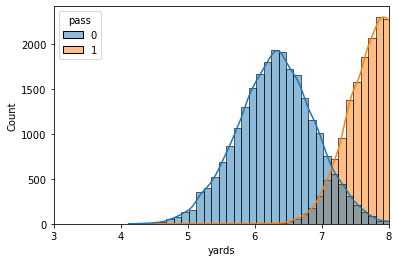

In [42]:
prob_pass1 = linear(1, 1, distance, b_pass, b_down, b_distance, b0)
prob_pass1 = pd.DataFrame(prob_pass1.T, columns =['yards'])
prob_pass1['pass'] = 1

prob_run1 = linear(0, 1, distance, b_pass, b_down, b_distance, b0)
prob_run1 = pd.DataFrame(prob_run1.T, columns =['yards'])
prob_run1['pass'] = 0

prob = pd.concat([prob_pass, prob_run], axis=0).reset_index(drop=True)

plt = sns.histplot(data=prob, x="yards", hue="pass", kde=True, bins=50)
plt.set_xlim(3,8)

(3.0, 8.0)

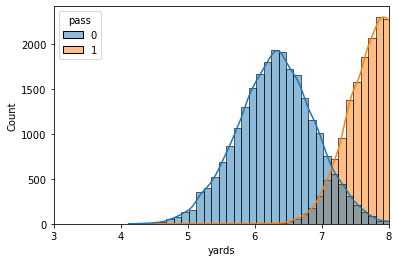

In [43]:
prob_pass2 = linear(1, 2, distance, b_pass, b_down, b_distance, b0)
prob_pass2 = pd.DataFrame(prob_pass2.T, columns =['yards'])
prob_pass2['pass'] = 1

prob_run2 = linear(0, 2, distance, b_pass, b_down, b_distance, b0)
prob_run2 = pd.DataFrame(prob_run2.T, columns =['yards'])
prob_run2['pass'] = 0

prob = pd.concat([prob_pass, prob_run], axis=0).reset_index(drop=True)

plt = sns.histplot(data=prob, x="yards", hue="pass", kde=True, bins=50)
plt.set_xlim(3,8)

(3.0, 8.0)

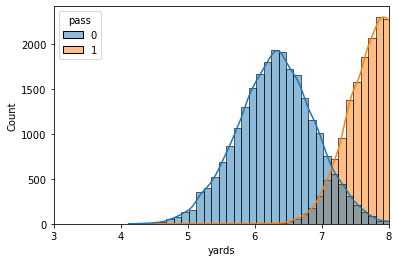

In [44]:
prob_pass3 = linear(1, 3, distance, b_pass, b_down, b_distance, b0)
prob_pass3 = pd.DataFrame(prob_pass3.T, columns =['yards'])
prob_pass3['pass'] = 1

prob_run3 = linear(0, 3, distance, b_pass, b_down, b_distance, b0)
prob_run3 = pd.DataFrame(prob_run3.T, columns =['yards'])
prob_run3['pass'] = 0

prob = pd.concat([prob_pass, prob_run], axis=0).reset_index(drop=True)

plt = sns.histplot(data=prob, x="yards", hue="pass", kde=True, bins=50)
plt.set_xlim(3,8)

(3.0, 8.0)

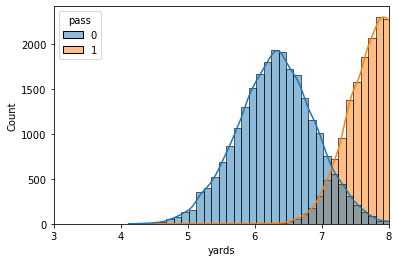

In [45]:
prob_pass4 = linear(1, 4, distance, b_pass, b_down, b_distance, b0)
prob_pass4 = pd.DataFrame(prob_pass4.T, columns =['yards'])
prob_pass4['pass'] = 1

prob_run4 = linear(0, 4, distance, b_pass, b_down, b_distance, b0)
prob_run4 = pd.DataFrame(prob_run4.T, columns =['yards'])
prob_run4['pass'] = 0

prob = pd.concat([prob_pass, prob_run], axis=0).reset_index(drop=True)

plt = sns.histplot(data=prob, x="yards", hue="pass", kde=True, bins=50)
plt.set_xlim(3,8)

In [18]:
burned_trace.varnames

['β0', 'β_pass', 'β_down', 'β_distance', 'sigma_log__', 'sigma']

In [51]:
np.mean([i>j for i, j in zip(list(prob_pass4['yards'].values), list(prob_run4['yards'].values))])*100

99.97916666666666